In [1]:
###### importing dependencies #############################################
import pprint
import seaborn as sns
import cryptoaml.datareader as cdr
from collections import OrderedDict
from cryptoaml.metrics import results_table, plot_confusion_matrix, plot_time_indexed_results
from cryptoaml.models import RandomForestAlgo, XgboostAlgo, LightGbmAlgo, CatBoostAlgo

/home/delinvas/anaconda3/envs/btc-classifier/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# models without tuning 
elliptic = cdr.get_data("elliptic")
elliptic_sets = elliptic.train_test_split(train_size=0.7, 
                                          feat_set="AF", 
                                          inc_meta=False)

In [3]:
# models with default parameters  
models_default = OrderedDict()

rf_default = RandomForestAlgo(n_jobs=-1, n_estimators=50, max_features=50)
models_default[rf_default.model_name_] = rf_default

# Using the default values for XGBoost Classifier will obtain reproducable results 
# => 'gblinear' booster with shotgun updater is nondeterministic as it uses Hogwild algorithm [Default='gbtree']
# =>  parameters such as subsample and colsample_by_* are set to 1, meaning no random sampling will be used 
xgb_default = XgboostAlgo(n_jobs=-1)
models_default[xgb_default.model_name_] = xgb_default

light_default = LightGbmAlgo(n_jobs=-1)
models_default[light_default.model_name_] = light_default

cat_default = CatBoostAlgo(thread_count=-1, verbose=False)
models_default[cat_default.model_name_] = cat_default

In [4]:
light_default.fit(elliptic_sets.train_X, elliptic_sets.train_y)

In [5]:
xgb_default.fit(elliptic_sets.train_X, elliptic_sets.train_y)

In [6]:
rf_default.fit(elliptic_sets.train_X, elliptic_sets.train_y)

In [7]:
cat_default.fit(elliptic_sets.train_X, elliptic_sets.train_y)

LIGHT: 0.9668508287292817
XGB: 0.9643835616438357
RF: 0.9693593314763231
CAT: 0.9752066115702479
LIGHT: 0.9142857142857143
XGB: 0.8918918918918919
RF: 0.868421052631579
CAT: 0.9411764705882354
LIGHT: 0.787878787878788
XGB: 0.7692307692307693
RF: 0.7575757575757575
CAT: 0.7692307692307693
LIGHT: 0.9295774647887325
XGB: 0.9345794392523364
RF: 0.9383886255924171
CAT: 0.937799043062201
LIGHT: 0.9559748427672956
XGB: 0.9487179487179487
RF: 0.9382716049382716
CAT: 0.9419354838709678
LIGHT: 0.7724867724867723
XGB: 0.7724867724867723
RF: 0.7668393782383419
CAT: 0.7765957446808511
LIGHT: 0.9478260869565217
XGB: 0.9473684210526316
RF: 0.9469026548672567
CAT: 0.96
LIGHT: 0.8695652173913043
XGB: 0.8616780045351473
RF: 0.8689655172413793
CAT: 0.8703703703703705
LIGHT: 0.0
XGB: 0.0
RF: 0.0
CAT: 0.0
LIGHT: 0.06060606060606061
XGB: 0.04761904761904762
RF: 0.05405405405405406
CAT: 0.058823529411764705
LIGHT: 0.0
XGB: 0.0
RF: 0.0
CAT: 0.0
LIGHT: 0.22222222222222224
XGB: 0.14285714285714285
RF: 0.2857142

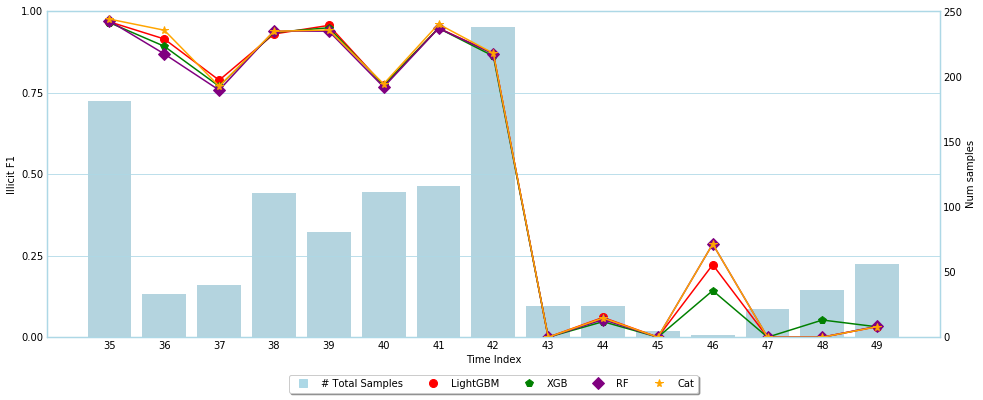

In [8]:
lf_split = elliptic_sets
# display(lf_split.test_X)
# display(lf_split.test_y)
mergedDf = lf_split.test_X.merge(lf_split.test_y, left_index=True, right_index=True)

# display(mergedDf)

gb = mergedDf.groupby("ts")    

time_indexed = [gb.get_group(x) for x in gb.groups]
time_indexed[1]
len(time_indexed)


time_steps = [] 
total_samples = []
scores_random = []
scores_light = []
scores_xgb = []
scores_cat = []


for ts in time_indexed:
    tmp_x = ts.loc[:, ts.columns != "class"]
    tmp_y = ts["class"]
#     display(tmp_x)
#     display(tmp_y)
   
    f1 = light_default.evaluate(metrics="f1", X=tmp_x, y=tmp_y)
    scores_light.append(f1["f1"])    
    print("LIGHT: " + str(f1["f1"]))
    
    f1 = xgb_default.evaluate(metrics="f1", X=tmp_x, y=tmp_y)
    scores_xgb.append(f1["f1"])
    print("XGB: " + str(f1["f1"]))

    f1 = rf_default.evaluate(metrics="f1", X=tmp_x, y=tmp_y)
    scores_random.append(f1["f1"])
    print("RF: " + str(f1["f1"]))

    
    f1 = cat_default.evaluate(metrics="f1", X=tmp_x, y=tmp_y)
    scores_cat.append(f1["f1"])
    print("CAT: " + str(f1["f1"]))
        
    time_steps.append(ts["ts"].unique()[0])
    total_pos_label = ts[ts["class"] == 1].shape[0]
    total_samples.append(total_pos_label)


scores = [("LightGBM", scores_light), ("XGB", scores_xgb), ("RF", scores_random), ("Cat", scores_cat)]

# ax = sns.barplot(x=)

print(scores)

# print(time_steps)
# print(total_samples)

# import matplotlib.pyplot as plt

plot_time_indexed_results(time_steps, 
                          total_samples,
                          scores,
                          metric_title="Illicit F1")


# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd

# fig = plt.figure()|
# ax1 = fig.add_subplot(111)
# ax1.plot(pd.Series(np.random.uniform(0,1,size=10)), color='g')
# ax2 = ax1.twinx()
# ax2.plot(pd.Series(np.random.uniform(0,17,size=10)), color='r')
# ax2.grid(False)
# plt.show()

In [9]:
# # extract results for elliptic dataset on different feature sets

# results = OrderedDict()
# results["elliptic"] = OrderedDict()
# metrics=["precision", "recall", "f1", "f1_micro", "confusion"]

# #extracting dataset results 
# for model_key, model in models_default.items():
#     print("\n######################################################")
#     print("Elliptic Dataset - Feature Set [{0}] ".format(model_key))
#     print("######################################################")
#     results["elliptic"][model_key] = OrderedDict()
        
#     for feature_set, feature_set_data in elliptic_sets.items():
#         print("- Training & Extracting Results - Feature Set [{}]".format(feature_set))

#         if feature_set not in results["elliptic"][model_key]:
#             results["elliptic"][model_key][feature_set] = OrderedDict()

#         # train model with default parameters
#         tmp_train_X = feature_set_data.train_X
#         tmp_train_y = feature_set_data.train_y 
#         model.fit(tmp_train_X, tmp_train_y)

#         # extract results 
#         tmp_test_X = feature_set_data.test_X
#         tmp_test_y = feature_set_data.test_y
#         tmp_result = model.evaluate(metrics=metrics,
#                                     X=tmp_test_X, 
#                                     y=tmp_test_y)


#         print(pprint.pformat(tmp_result))
#         print(pprint.pformat(model.get_params()))
#         results["elliptic"][model_key][feature_set] = tmp_result        

In [10]:
# RF 
# 0.7801920161697827
# 0.8146214099216711

# 0.7828715365239295
# 0.8103626943005181

# XGBoost 
# 0.7794871794871795
# 0.7794871794871795

# 0.8026652998462326
# 0.8026652998462326

# Light 
# 0.7789580171977744
# 0.7789580171977744

# 0.813929313929314
# 0.813929313929314

# CAT 
# 0.7892004153686397
# 0.7892004153686397
# 0.7892004153686397

# 0.8187565858798735
# 0.8187565858798735
# 0.8187565858798735

In [11]:
# display results 
# print(results)
# models = [x[0] for x in results["elliptic"]["LF"].items()]
# f1_scores = [x["f1"] for x in results["elliptic"]["LF"].values()]

# print(f1_scores)
# ax = sns.barplot(x=models, y=f1_scores)
# ax.set(ylim=(0, 1))



In [12]:
# f1_scores = [x["f1"] for x in results["elliptic"]["AF"].values()]

# print(f1_scores)
# ax = sns.barplot(x=models, y=f1_scores)
# ax.set(ylim=(0, 1))

In [13]:
# confusion_matrices = []

# for model, x in results["elliptic"].items():
#     for f, n in x.items():
# #         confusion_matrices.append(n["confusion"])
#          confusion_matrices.append((model + "_" + f, n["confusion"]))

# print(confusion_matrices)



In [14]:

# confusion_plt(confusion_matrices[0], "test")


# fig = plt.figure(figsize=(17,15))
# fig.subplots_adjust(hspace=0.3, wspace=0.2)
# i = 1

# for x in confusion_matrix:
#     ax = fig.add_subplot(2, 2, i)
#     sns.set(font_scale=1.4) 
#     confusion_plt(x, "test")
#     i = i+1
       
        
# plot_confusion_matrix(confusion_matrices, figsize=(17,20))

In [15]:
# split = elliptic_sets["AF"]
# display(split.test_X)